**Assignment 2 : 6 Marks total**

Broadly there are three different ways of approaching a sentiment analysis problem:

1. Rule based (Dictionary based, Vader)
2. Feature based (Logistic Regression, SVM)
3. Embedding based (Word2Vec, Deeplearning NLP models)

## Where does VADER Fail?

In demo, you saw how better VADER model is for analyzing social media texts. However, on more nuanced examples, it performs poorly. 

Consider the review “everything tastes like garbage to me but we keep coming back because my wife loves the pasta”. Clearly the reviewer does NOT like this restaurant, despite the fact that his or her wife “loves” the pasta. So for humans, this review is a clear negative. 

Let's see what VADER does. 

### Install Python Vader Library first

In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.8MB/s 


### Import the library

**2 Marks**

In [0]:
from --Fill-- import --Fill-- # Hint: Go through Demo notebook
analyser = --Fill--

### Scoring

We will use the polarity_scores() method to obtain the polarity indices for the given sentence.

In [0]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{} {}".format(sentence, str(score)))

Let us check how VADER performs on a given review:

In [0]:
sentiment_analyzer_scores("everything tastes like garbage to me but we keep coming back because my wife loves the pasta")

everything tastes like garbage to me but we keep coming back because my wife loves the pasta {'neg': 0.0, 'neu': 0.688, 'pos': 0.312, 'compound': 0.7783}


VADER instead returns a positive score of 0.7. It relies on the polarity of certain words to determine the overall sentiment. It doesn't have a broader syntactic understanding of the sentence.

## SVM based Sentiment Analysis

Let's perform a SVM based Sentiment Analysis based on Support a Vector Machine Model on Twitter Sentiments of US Airline passengers. 

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#Import Libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

In [0]:
# Import data
data = pd.read_csv("Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We take only the tweets we are very confident with. We use the BeautifulSoup library to process html encoding present in some tweets.

In [0]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

We are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

**1 Mark**

In [0]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(--Fill--) #Hint: Assign 1 to negative class and 0 to rest
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


We split the data into training and testing set:

In [0]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

Preprocessing the Data

In [0]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline.



**3 MARKS**

In [0]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [0]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, --Fill--(probability=True, 
                                             kernel= --Fill--, 
                                             class_weight= --Fill--)) #Hint : Linear kernel with balanced class weights

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.0min finished


0.9188979138877743

In [0]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 0.1}
0.9025857063886015


Let's see how the model (with the best hyperparameters) works on the test data:

In [0]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.8337605272793849,
 'auc': 0.9188967089480032,
 'f1': 0.8690888119953863,
 'precision': 0.9133333333333333,
 'recall': 0.828932893289329}

ROC Curve

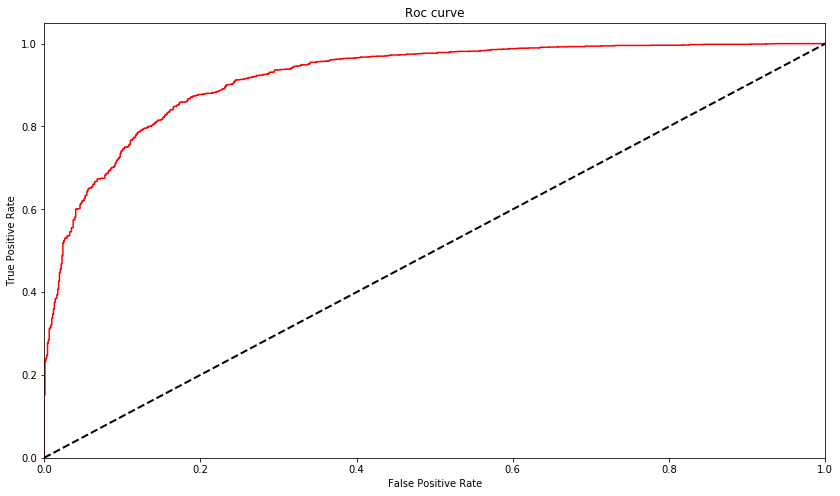

In [0]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

Prediction

In [0]:
pred = grid_svm.predict(["flying with @united is always a great experience."])
print('negative' if pred == np.array([1]) else 'not negative')

not negative


In [0]:
pred = grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])
print('negative' if pred == np.array([1]) else 'not negative')

negative


In [0]:
# Awesome right!